In [1]:
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

# Simulate data

In [2]:
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)

In [3]:
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]

x, y = np.meshgrid(np.linspace(-.75, .75, 3), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 3))

In [4]:
parameters = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.001,
               'baseline':0.0}).astype(np.float32)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

In [5]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel

In [6]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))

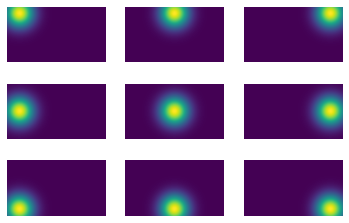

In [7]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(model.get_rf()[i].reshape((240, 135)).T)
    plt.axis("off")

## Predictions (no noise)

(150, 9)


<AxesSubplot:xlabel='time'>

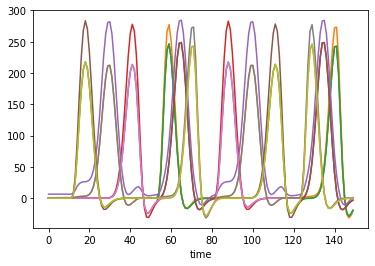

In [8]:
pred = model.predict()
pred.plot(legend=False)

## Noisy predictions

(1, 150, 9)


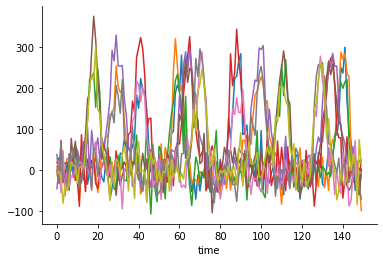

In [9]:
data = model.simulate(noise=35)
data.plot(legend=False)
sns.despine()

# Estimate parameters

In [10]:
from braincoder.optimize import ParameterFitter

In [11]:
fitter = ParameterFitter(model, data, paradigm)

In [12]:
grid_pars = fitter.fit_grid(x=np.linspace(-1, 1, 20), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 10),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)

Working with chunk size of 493827
Using correlation cost!


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


In [13]:
grid_pars

,x,y,sd,baseline,amplitude
0,-0.789474,-0.444079,0.23,0.0,1.0
1,0.052632,-0.444079,0.23,0.0,1.0
2,0.789474,-0.444079,0.23,0.0,1.0
3,-0.789474,0.029605,0.23,0.0,1.0
4,0.052632,0.029605,0.23,0.0,1.0
5,0.789474,0.029605,0.23,0.0,1.0
6,-0.789474,0.503289,0.23,0.0,1.0
7,-0.052632,0.444079,0.23,0.0,1.0
8,0.789474,0.444079,0.23,0.0,1.0


In [14]:
ols_pars = fitter.refine_baseline_and_amplitude(grid_pars)

(150, 9)
Original mean r2: -1404240.625
(150, 9)
100.00% of time lines improved
(150, 9)
New mean r2 after OLS: 0.832313060760498
(150, 9)
Original mean r2: 0.832313060760498
(150, 9)
11.11% of time lines improved
(150, 9)
New mean r2 after OLS: 0.8323131203651428


In [15]:
ols_pars

,x,y,sd,baseline,amplitude
0,-0.789474,-0.444079,0.23,-2.551027,0.000904
1,0.052632,-0.444079,0.23,-6.318160,0.000914
2,0.789474,-0.444079,0.23,-4.047384,0.000922
3,-0.789474,0.029605,0.23,-1.167647,0.000892
4,0.052632,0.029605,0.23,-3.837953,0.000831
5,0.789474,0.029605,0.23,-1.893424,0.000866
6,-0.789474,0.503289,0.23,-6.083654,0.001028
7,-0.052632,0.444079,0.23,-5.049799,0.000861
8,0.789474,0.444079,0.23,1.181548,0.000903


In [16]:
refined_pars = fitter.fit(init_pars=ols_pars, learning_rate=0.0001)


  0%|          | 0/1000 [00:00<?, ?it/s]

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 9


Current R2: 0.84277/Best R2: 0.84277: 100%|██████████| 1000/1000 [00:21<00:00, 45.82it/s]


(150, 9)


In [17]:
refined_pars

parameter,x,y,sd,baseline,amplitude
0,-0.755746,-0.422122,0.213389,-2.550081,0.000918
1,0.005423,-0.461211,0.224299,-6.242060,0.000984
2,0.766618,-0.432760,0.213340,-3.989886,0.000962
3,-0.771548,0.014744,0.212545,-1.097386,0.000972
4,0.006617,0.001696,0.215835,-3.873528,0.000913
5,0.763593,-0.000538,0.213433,-1.850292,0.000933
6,-0.733149,0.465944,0.214009,-6.160585,0.000984
7,-0.011828,0.431474,0.220372,-5.025882,0.000895
8,0.756817,0.447666,0.214665,1.238090,0.000954


In [18]:
r2 = fitter.get_rsq(refined_pars)
r2

(150, 9)


0    0.801603
1    0.873474
2    0.794888
3    0.849804
4    0.900591
5    0.878805
6    0.828224
7    0.838835
8    0.818713
dtype: float32

# Mexican hat model

In [19]:
from braincoder.models import DifferenceOfGaussiansPRF2DWithHRF

In [20]:
parameters_dog = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.001,
               'baseline':0.0,
               'srf_amplitude':.6, 
               'srf_factor':2.}).astype(np.float32)

In [21]:
model_dog = DifferenceOfGaussiansPRF2DWithHRF(grid_coordinates, paradigm, parameters=parameters_dog,
                                             hrf_model=SPMHRFModel(tr=1.8))

In [22]:
pred_dog = model_dog.predict()

(150, 9)


<AxesSubplot:xlabel='time'>

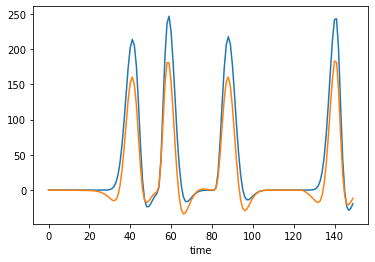

In [23]:
pred[0].plot()
pred_dog[0].plot()

(1, 150, 9)


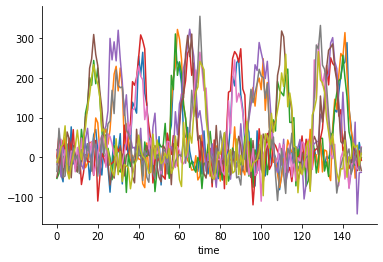

In [24]:
data_dog = model.simulate(noise=35)
data_dog.plot(legend=False)
sns.despine()

In [25]:
fitter = ParameterFitter(model_dog, data_dog, paradigm)

In [26]:
est_pars_dog = refined_pars.copy()
est_pars_dog['srf_amplitude'] = 0.1
est_pars_dog['srf_factor'] = 2.

In [27]:
est_pars_dog = fitter.fit(init_pars=est_pars_dog, learning_rate=0.001)


  0%|          | 0/1000 [00:00<?, ?it/s]

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 9


Current R2: 0.83900/Best R2: 0.83900: 100%|██████████| 1000/1000 [00:28<00:00, 34.61it/s]


(150, 9)


In [28]:
est_pred = model.predict(parameters=est_pars_dog)

(150, 9)


<AxesSubplot:xlabel='time'>

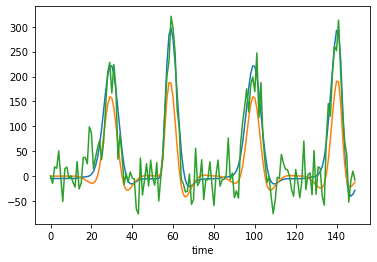

In [29]:
est_pred[1].plot()
pred_dog[1].plot()
data_dog[1].plot()

In [30]:
est_pars_dog

parameter,x,y,sd,baseline,amplitude,srf_amplitude,srf_factor
0,-0.754417,-0.439303,0.207583,-1.930064,0.001050,0.092631,1.921775
1,-0.004178,-0.419496,0.214388,-5.713326,0.001004,0.104240,1.948537
2,0.769697,-0.399072,0.218957,-3.861543,0.000961,0.105847,2.030954
3,-0.759169,0.003354,0.210181,-0.911464,0.001011,0.101647,1.993056
4,0.020893,0.006055,0.218289,-4.197105,0.000943,0.102792,2.023346
5,0.728052,0.012849,0.193722,-1.365533,0.001132,0.099109,1.929634
6,-0.751645,0.433578,0.223152,-5.349352,0.000964,0.101515,1.941720
7,-0.017843,0.434814,0.229855,-5.068067,0.000949,0.105115,2.040615
8,0.773062,0.457883,0.231931,1.286803,0.000925,0.099809,2.103787


In [31]:
parameters_dog

,x,y,sd,amplitude,baseline,srf_amplitude,srf_factor
0,-0.75,-0.421875,0.2,0.001,0.0,0.6,2.0
1,0.00,-0.421875,0.2,0.001,0.0,0.6,2.0
2,0.75,-0.421875,0.2,0.001,0.0,0.6,2.0
3,-0.75,0.000000,0.2,0.001,0.0,0.6,2.0
4,0.00,0.000000,0.2,0.001,0.0,0.6,2.0
5,0.75,0.000000,0.2,0.001,0.0,0.6,2.0
6,-0.75,0.421875,0.2,0.001,0.0,0.6,2.0
7,0.00,0.421875,0.2,0.001,0.0,0.6,2.0
8,0.75,0.421875,0.2,0.001,0.0,0.6,2.0


In [32]:
r2 = fitter.get_rsq()

(150, 9)


In [33]:
r2

0    0.817066
1    0.842139
2    0.819168
3    0.867326
4    0.862071
5    0.883170
6    0.802847
7    0.858739
8    0.798472
dtype: float32